# Pattern classification
This tutorial is about the basics of pattern classification analysis.

It is based partly on the two online textbook chapters here:

https://lukas-snoek.com/NI-edu/fMRI-pattern-analysis/week_1/design_and_pattern_estimation.html

http://neuroimaging-data-science.org/content/007-ml/002-sklearn.html

Material has also been taken from the Scikit-learn example on permutation testing:

https://scikit-learn.org/stable/auto_examples/model_selection/plot_permutation_tests_for_classification.html#permutation-test-score


In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

## What makes up a "pattern"?
What do we mean with the term "pattern" in pattern classification? There are different options with regard to *what you choose as your unit of measurement* that makes up your pattern. The far majority of pattern analyses in functional MRI use patterns of *activity estimates*, i.e., the same unit of measurement &mdash; relative (de)activation &mdash; as is common in standard mass-univariate analyses. For example, decoding object category (e.g., images of faces vs. images of houses) from fMRI activity patterns in inferotemporal cortex is an example of a pattern analysis that uses *activity estimates* as its unit of measurement. 

However, you are definitely not limited to using *activity estimates* for your patterns. For example, you could apply pattern analyses to structural data (e.g., patterns of voxelwise gray-matter volume values, like in [voxel-based morphometry](https://en.wikipedia.org/wiki/Voxel-based_morphometry)) or to functional connectivity data (e.g., patterns of time series correlations between voxels, or even topological properties of brain networks). (In fact, the connectivity examples from the Nilearn tutorial represents a way to estimate these connectivity features, which can be used in pattern analyses.) In short, pattern analyses can be applied to patterns composed of *any* type of measurement or metric!

Now, let's get a little more technical. Usually, as mentioned in the beginning, pattern analyses represent the data as a 2D array of brain patterns. Let's call this $\mathbf{R}$. The rows of $\mathbf{R}$ represent different instances of patterns (sometimes called "samples" or "observations") and the columns represent different brain features (e.g., voxels; sometimes simply called "features"). Note that we thus lose all spatial information by "flattening" our patterns into 1D rows!

Let's call the number of samples $N$ and the number of brain features $K$. We can thus represent $\mathbf{R}$ as a $N\times K$ matrix (2D array):

\begin{align}
\mathbf{R} = 
\begin{bmatrix}
 R_{1,1} & R_{1,2} & R_{1,3} & \dots & R_{1,K}\\
 R_{2,1} & R_{1,2} & R_{1,3} & \dots & R_{2,K}\\
 R_{3,1} & R_{1,2} & R_{1,3} & \dots & R_{3,K}\\
 \vdots & \vdots & \vdots & \ddots & \vdots\\ 
 R_{N,1} & R_{1,2} & R_{1,3} & \dots & R_{N,K}\\
\end{bmatrix}
\end{align}

As discussed before, the values themselves (e.g., $R_{1,1}$, $R_{1,2}$, $R_{3,6}$) represent whatever you chose for your patterns (fMRI or EEG/MEG activity, connectivity estimates, VBM, etc.). What is represented by the rows (samples/observations) of $\mathbf{R}$ depends on your study design: in between-subject studies, these are usually participants, while in within-subject studies, these samples represent trials (or averages of trials or sometimes runs). The columns of $\mathbf{R}$ represent the different (brain) features in your pattern; for example, these may be different voxels (or sensors/magnetometers in EEG/MEG), vertices (when working with cortical surfaces), edges in functional brain networks, etc. etc. 

Let's make it a little bit more concrete. We'll make up some random data below that represents a typical data array in pattern analyses:

In [22]:
import numpy as np
N = 100  # e.g. trials
K = 250   # e.g. voxels

R = np.random.normal(0, 1, size=(N, K))
R

array([[-1.23107736,  0.13611646,  0.6733977 , ...,  0.85031543,
        -0.50345991,  0.5015948 ],
       [-1.20555333,  1.23045546, -0.33187265, ...,  0.28337803,
         0.08959747, -0.14941015],
       [ 2.04148792, -1.74182084, -0.5085704 , ...,  1.1228185 ,
        -0.35020289,  0.91137612],
       ...,
       [-0.64789404, -0.28957204, -0.04964835, ...,  0.89129836,
        -0.774445  , -1.15819225],
       [ 0.13341541,  1.82605779,  1.05668632, ..., -1.37820179,
        -0.28102872, -0.64243239],
       [-1.76993187, -0.32977089, -0.60230473, ...,  0.1975542 ,
        -0.87012568,  0.76742351]])

Let's visualize this:

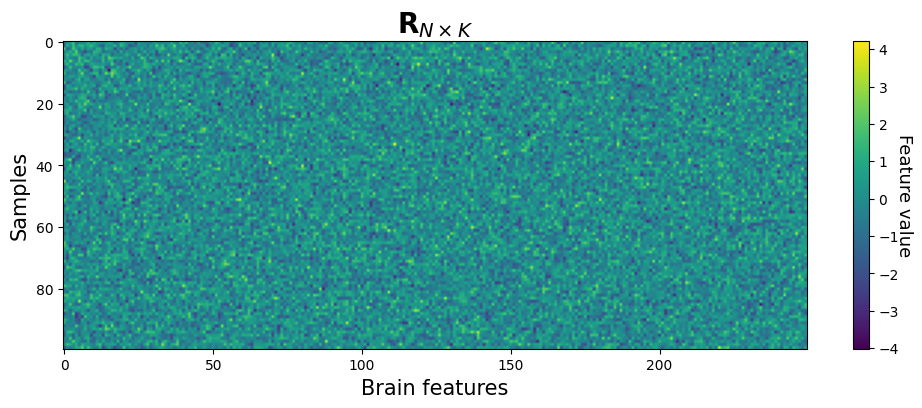

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 4))
plt.imshow(R, aspect='auto')
plt.xlabel('Brain features', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.title(r'$\mathbf{R}_{N\times K}$', fontsize=20)
cbar = plt.colorbar()
cbar.set_label('Feature value', fontsize=13, rotation=270, labelpad=10)
plt.show()

Matrix indexing reminder: If we want to extract the pattern of the 42nd trial and store it in a variable called <tt>trial42</tt> and extract the values of 187th brain feature across all trials and store it in a variable called <tt>feat187</tt>, we can do this using the following script.

In [24]:
trial42 = R[41, :]
feat187 = R[:, 186]

Alright, to practice a little bit more. We included whole-brain VBM data for 20 subjects in the `data/vbm/` subfolder:

In [25]:
import os
data_path = os.path.join("..", "data", "vbm")
sorted(os.listdir(data_path))

['sub-01.nii.gz',
 'sub-02.nii.gz',
 'sub-03.nii.gz',
 'sub-04.nii.gz',
 'sub-05.nii.gz',
 'sub-06.nii.gz',
 'sub-07.nii.gz',
 'sub-08.nii.gz',
 'sub-09.nii.gz',
 'sub-10.nii.gz',
 'sub-11.nii.gz',
 'sub-12.nii.gz',
 'sub-13.nii.gz',
 'sub-14.nii.gz',
 'sub-15.nii.gz',
 'sub-16.nii.gz',
 'sub-17.nii.gz',
 'sub-18.nii.gz',
 'sub-19.nii.gz',
 'sub-20.nii.gz']

The VBM data represents spatially normalized (to MNI152, 2mm), whole-brain voxelwise gray matter volume estimates (read more about VBM [here](https://en.wikipedia.org/wiki/Voxel-based_morphometry)).

Let's inspect the data from a single subject:

Shape of Nifti file:  (91, 109, 91)


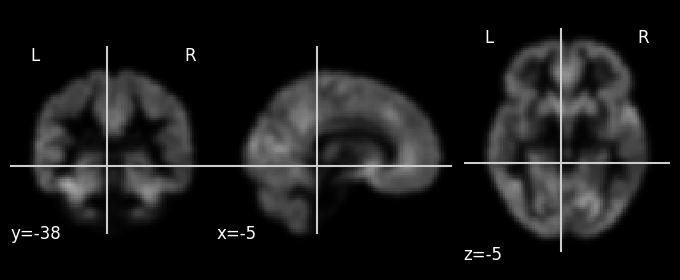

In [26]:
import os
import nibabel as nib
from nilearn import plotting

sub_01_vbm_path = os.path.join("..", 'data', "vbm", 'sub-01.nii.gz')
sub_01_vbm = nib.load(sub_01_vbm_path)
print("Shape of Nifti file: ", sub_01_vbm.shape)

# Let's plot it as well
plotting.plot_anat(sub_01_vbm)
plt.show()

As you can see, the VBM data is a 3D array of shape 91 ($X$) $\times$ 109 ($Y$) $\times$ 91 ($Z$) (representing voxels). These are the spatial dimensions associated with the standard MNI152 (2 mm) template provided by FSL. As VBM is structural (not functional!) data, there is no time dimension ($T$).

Now, suppose that we want to do a pattern analysis on the data of all 20 subjects. We should then create a 2D array of shape 20 (subjects) $\times\ K$ (number of voxels, i.e., $91 \times 109 \times 91$). To do so, we need to create a loop over all files, load them in, "flatten" the data, and ultimately stack them into a 2D array. 

We will start by visiting a neat Python function called `glob`, which allows you to simply find files using "[wildcards](https://en.wikipedia.org/wiki/Wildcard_character)":

In [27]:
from glob import glob

It works as follows:

```
list_of_files = glob('path/with/subdirectories/*/*.nii.gz')
```

Importantly, the string you pass to `glob` can contain one or more wildcard characters (such as `?` or `*`). Also, *the returned list is not sorted*! Let's try to get all our VBM subject data into a list using this function:

In [28]:
# Let's define a "search string"; we'll use the os.path.join function
# to make sure this works both on Linux/Mac and Windows
search_str = os.path.join("..", 'data/vbm', 'sub-*.nii.gz')
vbm_files = glob(search_str)

# this is also possible: vbm_files = glob(os.path.join('vbm', 'sub-*.nii.gz'))

# Let's print the returned list
print(vbm_files)

['../data/vbm/sub-16.nii.gz', '../data/vbm/sub-12.nii.gz', '../data/vbm/sub-13.nii.gz', '../data/vbm/sub-18.nii.gz', '../data/vbm/sub-14.nii.gz', '../data/vbm/sub-19.nii.gz', '../data/vbm/sub-07.nii.gz', '../data/vbm/sub-09.nii.gz', '../data/vbm/sub-06.nii.gz', '../data/vbm/sub-01.nii.gz', '../data/vbm/sub-10.nii.gz', '../data/vbm/sub-17.nii.gz', '../data/vbm/sub-20.nii.gz', '../data/vbm/sub-08.nii.gz', '../data/vbm/sub-15.nii.gz', '../data/vbm/sub-11.nii.gz', '../data/vbm/sub-02.nii.gz', '../data/vbm/sub-04.nii.gz', '../data/vbm/sub-03.nii.gz', '../data/vbm/sub-05.nii.gz']


As you can see, *the list is not alphabetically sorted*, so let's fix that with the `sorted` function:

In [29]:
vbm_files = sorted(vbm_files)
print(vbm_files)
# Note that we could have done that with a single statement
# vbm_files = sorted(glob(os.path.join('vbm', 'sub-*.nii.gz')))
# But also remember: shorter code is not always better!

['../data/vbm/sub-01.nii.gz', '../data/vbm/sub-02.nii.gz', '../data/vbm/sub-03.nii.gz', '../data/vbm/sub-04.nii.gz', '../data/vbm/sub-05.nii.gz', '../data/vbm/sub-06.nii.gz', '../data/vbm/sub-07.nii.gz', '../data/vbm/sub-08.nii.gz', '../data/vbm/sub-09.nii.gz', '../data/vbm/sub-10.nii.gz', '../data/vbm/sub-11.nii.gz', '../data/vbm/sub-12.nii.gz', '../data/vbm/sub-13.nii.gz', '../data/vbm/sub-14.nii.gz', '../data/vbm/sub-15.nii.gz', '../data/vbm/sub-16.nii.gz', '../data/vbm/sub-17.nii.gz', '../data/vbm/sub-18.nii.gz', '../data/vbm/sub-19.nii.gz', '../data/vbm/sub-20.nii.gz']


Next, we will create a 2D array with the vertically stacked subject-specific (flattened) VBM patterns, in which the first subject should be the first row. We want to pre-allocate this array before starting your loop (using, <tt>np.zeros</tt>). We will store the final 2D array in a variable named <tt>R_vbm</tt>.

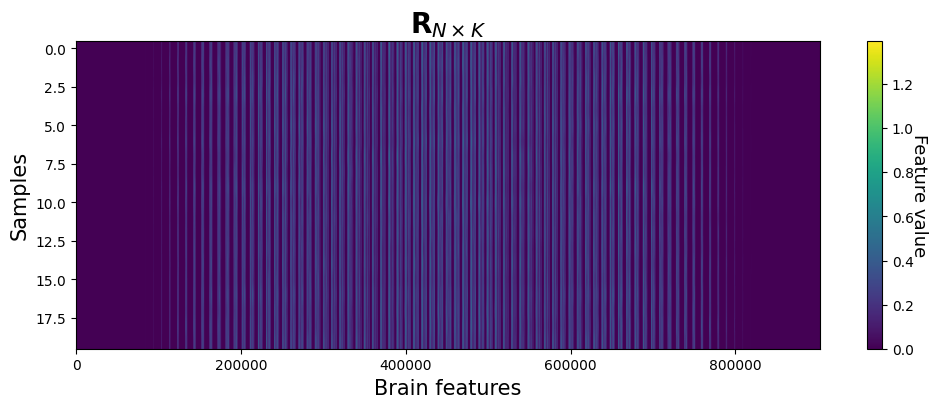

In [30]:

R_vbm = np.zeros((len(vbm_files), 91 * 109 * 91))
for i, f in enumerate(vbm_files):
    R_vbm[i, :] = nib.load(f).get_fdata().flatten()

   
plt.figure(figsize=(12, 4))
plt.imshow(R_vbm, aspect='auto')
plt.xlabel('Brain features', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.title(r'$\mathbf{R}_{N\times K}$', fontsize=20)
cbar = plt.colorbar()
cbar.set_label('Feature value', fontsize=13, rotation=270, labelpad=10)
plt.show()

<div class='alert alert-success'>
    <b>Tip</b>: While it is a good exercise to load in the data yourself, you can also easily load in and concatenate a set of Nifti files using Nilearn's <a href="https://nilearn.github.io/modules/generated/nilearn.image.concat_imgs.html">concat_imgs</a> function (which returns a 4D <tt>Nifti1Image</tt>, with the different patterns as the fourth dimension). You'd still have to reorganize this data into a 2D array, though.
</div>

In [31]:
# Run this cell after you're done.
# This will remove the all numpy arrays from memory,
# clearing up RAM for the next sections
%reset -f array

### Patterns as "points in space"
Before we continue with the topic of pattern estimation, there is one idea that we'd like to introduce: thinking of patterns as points (i.e., coordinates) in space. Thinking of patterns this way is helpful to understanding both machine learning based analyses and representational similarity analysis. While for some, this idea might sound trivial, we believe it's worth going over anyway. Now, let's make this idea more concrete. 

Suppose we have estimated fMRI activity patterns for 20 trials (rows of $\mathbf{R}$). Now, we will also assume that those patterns consist of only two features (e.g., voxels; columns of $\mathbf{R}$), because this will make visualizing patterns as points in space easier than when we choose a larger number of features.

Alright, let's simulate and visualize the data (as a 2D array):

Shape of R: (20, 2)


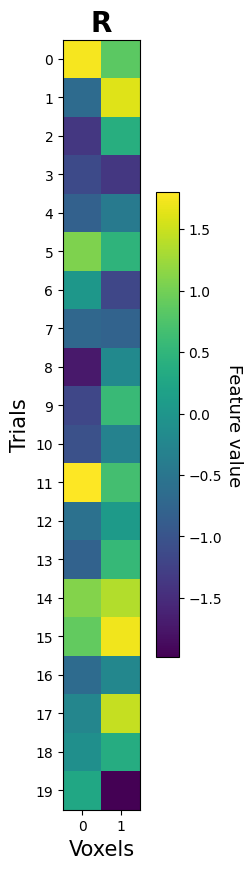

In [32]:
K = 2  # features (voxels)
N = 20  # samples (trials)

R = np.random.multivariate_normal(np.zeros(K), np.eye(K), size=N)

print("Shape of R:", R.shape)

# Plot 2D array as heatmap
fig, ax = plt.subplots(figsize=(2, 10))
mapp = ax.imshow(R)
cbar = fig.colorbar(mapp, pad=0.1)
cbar.set_label('Feature value', fontsize=13, rotation=270, labelpad=15)
ax.set_yticks(np.arange(N))
ax.set_xticks(np.arange(K))
ax.set_title(r"$\mathbf{R}$", fontsize=20)
ax.set_xlabel('Voxels', fontsize=15)
ax.set_ylabel('Trials', fontsize=15)
plt.show()

Now, we mentioned that each pattern (row of $\mathbf{R}$, i.e., $\mathbf{R}_{i}$) can be interpreted as a point in 2D space. With space, here, we mean a space where each feature (e.g., voxel; column of $\mathbf{R}$, i.e., $\mathbf{R}_{j}$) represents a separate axis. In our simulated data, we have two features (e.g., voxel 1 and voxel 2), so our space will have two axes:

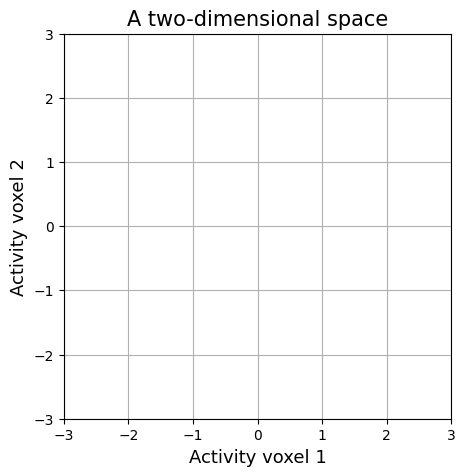

In [33]:
plt.figure(figsize=(5, 5))
plt.title("A two-dimensional space", fontsize=15)
plt.grid()
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel('Activity voxel 1', fontsize=13)
plt.ylabel('Activity voxel 2', fontsize=13)
plt.show()

Within this space, each of our patterns (samples) represents a point. The values of each pattern represent the *coordinates* of its location in this space. For example, the coordinates of the first pattern are:

In [34]:
print(R[0, :])

[1.74901326 0.83954748]


As such, we can plot this pattern as a point in space:

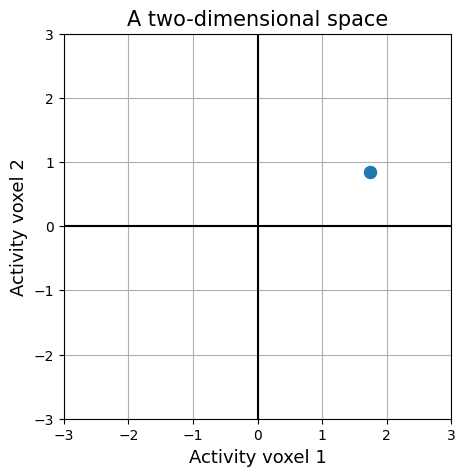

In [35]:
plt.figure(figsize=(5, 5))
plt.title("A two-dimensional space", fontsize=15)
plt.grid()

# We use the "scatter" function to plot this point, but
# we could also have used plt.plot(R[0, 0], R[0, 1], marker='o')
plt.scatter(R[0, 0], R[0, 1], marker='o', s=75)
plt.axhline(0, c='k')
plt.axvline(0, c='k')
plt.xlabel('Activity voxel 1', fontsize=13)
plt.ylabel('Activity voxel 2', fontsize=13)

plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

If we do this for all patterns, we get an ordinary scatter plot of the data:

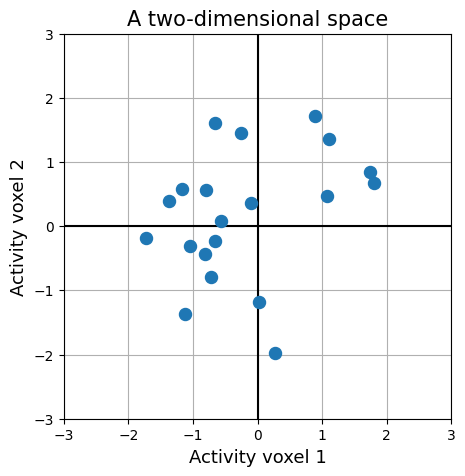

In [36]:
plt.figure(figsize=(5, 5))
plt.title("A two-dimensional space", fontsize=15)
plt.grid()

# We use the "scatter" function to plot this point, but
# we could also have used plt.plot(R[0, 0], R[0, 1], marker='o')
plt.axhline(0, c='k')
plt.axvline(0, c='k')
plt.scatter(R[:, 0], R[:, 1], marker='o', s=75, zorder=3)
plt.xlabel('Activity voxel 1', fontsize=13)
plt.ylabel('Activity voxel 2', fontsize=13)

plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

It is important to realize that both perspectives &mdash; as a 2D array and as a set of points in $K$-dimensional space &mdash; represents the same data! Practically, pattern analysis algorithms usually expect the data as a 2D array, but (in our experience) the operations and mechanisms implemented by those algorithms are easiest to explain and to understand from the "points in space" perspective.

You might think, "but how does this work for data with more than two features?" Well, the idea of patterns as points in space remains the same: each feature represents a new dimension (or "axis"). For three features, this means that a pattern represents a point in 3D (X, Y, Z) space; for four features, a pattern represents a point in 4D space (like a point moving in 3D space) ... but what about a pattern with 14 features? Or 500? Actually, this is impossible to visualize or even make sense of mentally. As the famous artificial intelligence researcher Geoffrey Hinton put it:

> "To deal with ... a 14 dimensional space, visualize a 3D space and say 'fourteen' very loudly. Everyone does it." (Geoffrey Hinton)

The important thing to understand, though, is that most operations, computations, and algorithms that deal with patterns do not care about whether your data is 2D (two features) or 14D (fourteen features) &mdash; we just have to trust the mathematicians that whatever we do on 2D data will generalize to $K$-dimensional data :-)

That said, people still try to visualize >2D data using *dimensionality reduction* techniques. These techniques try to project data to a lower-dimensional space. For example, you can transform a dataset with 500 features (i.e., a 500-dimensional dataset) to a 2D dimensional dataset using techniques such as principal component analysis (PCA), Multidimensional Scaling (MDS), and t-SNE. For example, PCA tries to a subset of uncorrelated lower-dimensional features (e.g., 2) from  linear combinations of high-dimensional features (e.g., 4) that still represent as much variance of the high-dimensional components as possible. We'll show you an example below using an implementation of PCA from the machine learning library [scikit-learn](https://scikit-learn.org/stable/), which we'll use extensively in next week's lab:

Shape R4D: (100, 4)
Shape R2D: (100, 2)


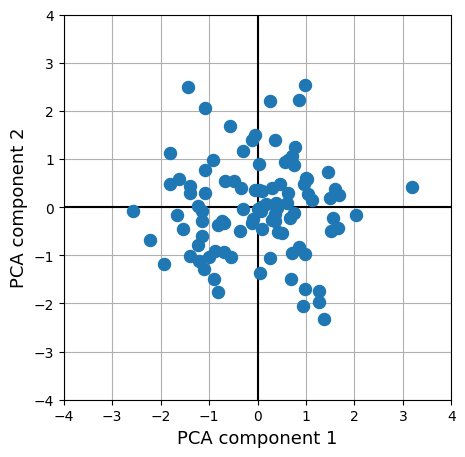

In [37]:
from sklearn.decomposition import PCA

# Let's create a dataset with 100 samples and 4 features
R4D = np.random.normal(0, 1, size=(100, 4))
print("Shape R4D:", R4D.shape)

# We'll instantiate a PCA object that will
# transform our data into 2 components
pca = PCA(n_components=2)

# Fit and transform the data from 4D to 2D
R2D = pca.fit_transform(R4D)
print("Shape R2D:", R2D.shape)

# Plot the result
plt.figure(figsize=(5, 5))
plt.scatter(R2D[:, 0], R2D[:, 1], marker='o', s=75, zorder=3)
plt.axhline(0, c='k')
plt.axvline(0, c='k')
plt.xlabel('PCA component 1', fontsize=13)
plt.ylabel('PCA component 2', fontsize=13)
plt.grid()
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

PCA is a specific dimensionality reduction technique that uses linear combinations of features to project the data to a lower-dimensional space with fewer "components". Linear combinations are simply weighted sums of high-dimensional features. In a 4D dimensional space that is project to 2D, PCA component 1 might be computed as $\mathbf{R}_{j=1}\theta_{1}+\mathbf{R}_{j=2}\theta_{2}+\mathbf{R}_{j=3}\theta_{3}+\mathbf{R}_{j=4}\theta_{4}$, where $R_{j=4}$ represents the 4th feature of $\mathbf{R}$ and $\theta_{4}$ represents the <em>weight</em> for the 4th feature.
    
The weights of the fitted PCA model can be accessed by, confusingly, <tt>pca.components_</tt> (shape: $K_{lower} \times K_{higher}$. Using these weights, you can recompute the lower-dimensional features from the higher-dimensional features? We'll try to plot it like the figure above and check whether it matches.

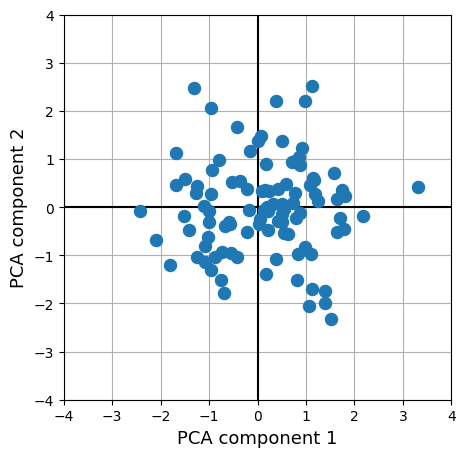

In [38]:
# Matrix multiplication appraoch
tmp = R4D @ pca.components_.T

# Alternative approach:
# c1 = np.sum(R4D * pca.components_[0, :], axis=1)
# c2 = np.sum(R4D * pca.components_[1, :], axis=1)
# tmp = np.c_[c1, c2]  <-- concatenate
plt.figure(figsize=(5, 5))
plt.scatter(tmp[:, 0], tmp[:, 1], marker='o', s=75, zorder=3)
plt.xlabel('PCA component 1', fontsize=13)
plt.ylabel('PCA component 2', fontsize=13)
plt.axhline(0, c='k')
plt.axvline(0, c='k')
plt.grid()
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()


Note that dimensionality reduction is often used for visualization, but it can also be used as a preprocessing step in pattern analyses.

## Pattern classification

Now that we have our pattern, we can think of what to do with it. One way to use patterns is if each row in the pattern represents some type of experimental condition or `class`of stimuli.
If different rows in our pattern represents different classes, we can try to use the pattern to predict the classes.
One of the main branches of machine learning is devoted to classification, and a bunch of different algorithms exist to do this.
Let's try some of them with a simpler or more complex 2D patterns.

Text(-6, -12.5, 'Class 2')

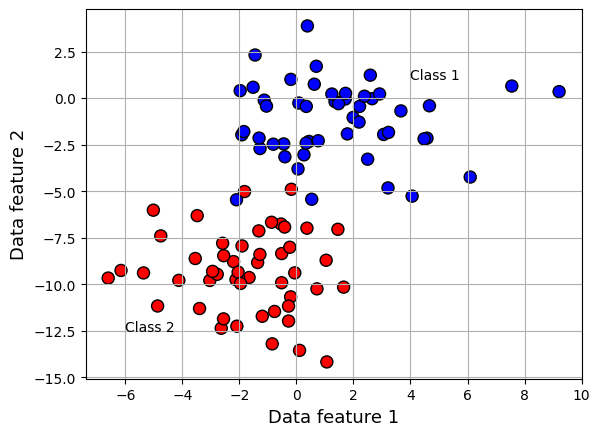

In [39]:
from sklearn.datasets import make_blobs
from matplotlib.colors import ListedColormap

cm_bright = ListedColormap(['#FF0000', '#0000FF'])
X, y = make_blobs(centers=2, cluster_std=2,random_state=2)
fig, ax = plt.subplots()
s = ax.scatter(*X.T, c=y, s=75,linewidth=1,edgecolors='k',cmap=cm_bright)
plt.grid()
plt.xlabel('Data feature 1', fontsize=13)
plt.ylabel('Data feature 2', fontsize=13)
plt.text(x=4,y=1, s='Class 1')
plt.text(x=-6,y=-12.5, s='Class 2')

### The Scikit-learn package

Scikit-learn is the most widely-used machine learning package in Python—and for that matter, probably in any programming language. Its popularity stems from its simple, elegant interface, [stellar documentation](https://scikit-learn.org/stable/documentation.html), and comprehensive support for many of the most widely used machine learning algorithms. Scikit-learn provides well-organized, high-quality tools for virtually all aspects of the typical machine learning workflow, including data loading and preprocessing, feature extraction and feature selection, dimensionality reduction, model selection, and evaluation, and so on.
### Classifier comparison
Below is a comparison of a several classifiers in scikit-learn on synthetic datasets. The point of this example is to illustrate the nature of decision boundaries of different classifiers. This should be taken with a grain of salt, as the intuition conveyed by these examples does not necessarily carry over to real datasets.

Particularly in high-dimensional spaces, data can more easily be separated linearly and the simplicity of classifiers such as naive Bayes and linear SVMs might lead to better generalization than is achieved by other classifiers.

The plots show training points in solid colors and testing points semi-transparent. The lower right shows the classification accuracy on the test set.

Example from [here](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

Automatically created module for IPython interactive environment
Classes:  [1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 0
 0 0 0 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1
 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1]


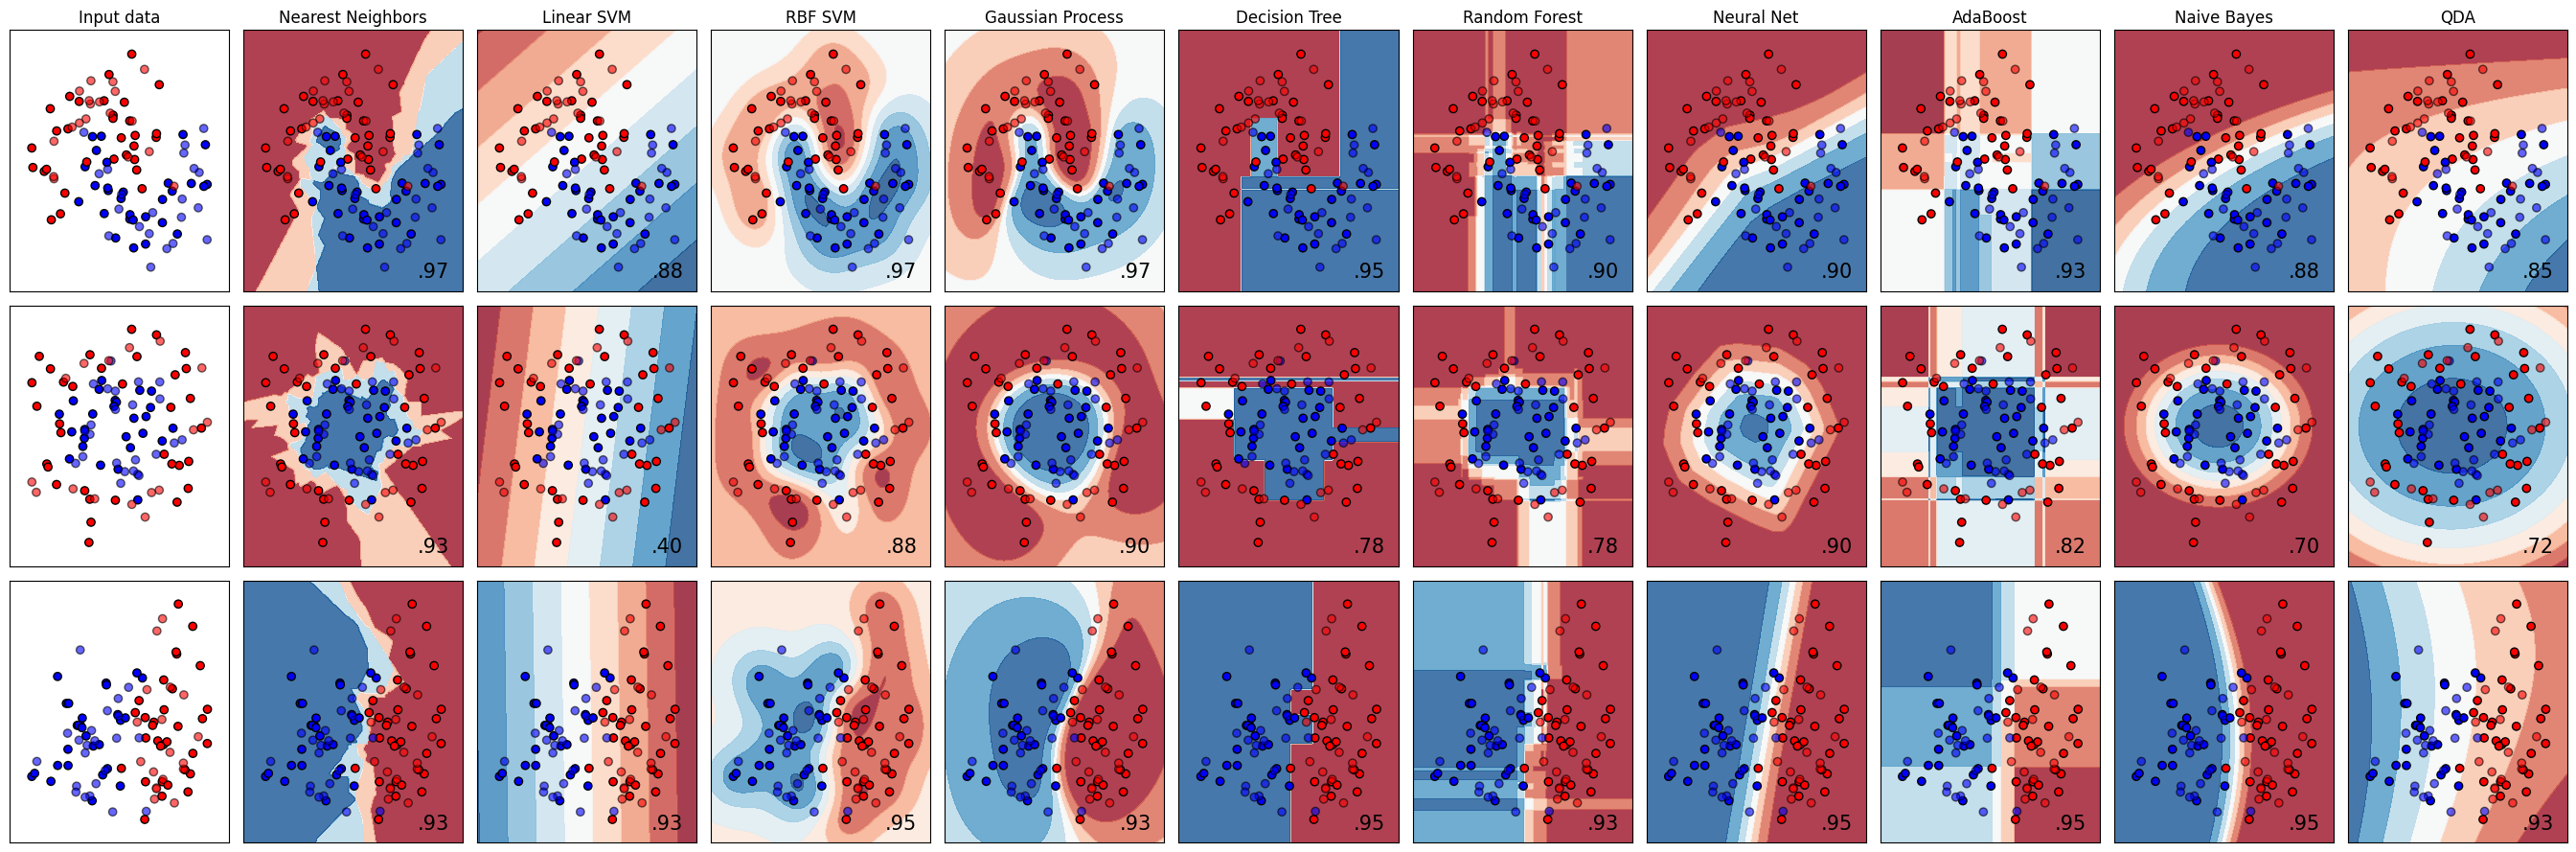

In [40]:
print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis




h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

# We will use these classifiers, just to illustrate the varieties
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

#Generate three different datasets for illustration of classifiers (see plot)
datasets = [make_moons(n_samples=100,noise=0.3, random_state=0),
            make_circles(n_samples=100,noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot( len(datasets),len(classifiers) + 1, i)
        #Fit the training data
        clf.fit(X_train, y_train)
        #Predict the test data, get score
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
            # Add accuracy scores
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

print('Classes: ', y)
plt.tight_layout()
plt.show()

<div class='alert alert-info'>
    <b>ToThink</b>: Try to think about situations where 2D data may have the shape used in the three example datasets ?
</div>

## The ABIDE-II dataset

To further illustrate how Scikit-learn works, we're going to need some data. Scikit-learn is built on top of Numpy, so in theory, we could use Numpy's random number generation routines to create suitable arrays for Scikit-learn, just as we did earlier. But that would be kind of boring. We already understand the basics of Numpy arrays at this point, so we can be a bit more ambitious here, and try to learn machine learning using a real neuroimaging dataset. For most of this chapter, we'll use a dataset drawn from the *Autism Brain Imaging Data Exchange II* (ABIDE II) project. ABIDE is an international consortium aimed at facilitating the study of autism spectrum disorder (ASD) by publicly releasing large-scale collections of structural neuroimaging data obtained from thousands of participants at dozens of research sites ([di Martino et al. 2017](https://www.nature.com/articles/sdata201710)). In the following, we'll use data from the second collection (hence the II in ABIDE II). To keep things simple, we're going to use a lightly preprocessed version of the ABIDE II dataset, provided in [Bethlehem et al. 2020](https://www.nature.com/articles/s42003-020-01212-9).

In [41]:
from ndslib.data import load_data
abide_data = load_data("abide2")

We can get a quick sense of the dataset's dimensions:

In [42]:
abide_data.shape

(1004, 1446)

And here are the first five rows:

In [43]:
display(abide_data.head(5))

,site,subject,age,sex,group,age_resid,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,ABIDEII-KKI_1,29293,8.893151,2.0,1.0,13.642852,2750.0,306.0,354.0,2123.0,...,3.362,2.827,2.777,2.526,3.202,3.024,3.354,2.629,2.699,3.179
1,ABIDEII-OHSU_1,28997,12.000000,2.0,1.0,16.081732,2836.0,186.0,354.0,2261.0,...,2.809,3.539,2.944,2.769,3.530,3.079,3.282,2.670,2.746,3.324
2,ABIDEII-GU_1,28845,8.390000,1.0,2.0,12.866264,3394.0,223.0,373.0,2827.0,...,2.435,3.321,2.799,2.388,3.148,3.125,3.116,2.891,2.940,3.232
3,ABIDEII-NYU_1,29210,8.300000,1.0,1.0,13.698139,3382.0,266.0,422.0,2686.0,...,3.349,3.344,2.694,3.030,3.258,2.774,3.383,2.696,3.014,3.264
4,ABIDEII-EMC_1,29894,7.772758,2.0,2.0,14.772459,3080.0,161.0,346.0,2105.0,...,2.428,2.940,2.809,2.607,3.430,2.752,2.645,3.111,3.219,4.128


We can see that each row contains data for a single participant and each column represents a different variable. The first 5 columns contain key identifiers and phenotypic variables: respectively, these include the research `site` the subject comes from (our dataset combines data from 17 different sites); the `subject`'s unique ID, and their `age` (in years), `sex`, and diagnosis `group` (where 1 indicates an autism diagnosis and 2 indicates a control subject). The sixth column is not in the original dataset and is a residualized version of the age variable that we'll talk more about later.

The remaining 1440 columns contain 4 sets of structural brain features extracted using the widely-used FreeSurfer package ([Fischl 2012](https://www.sciencedirect.com/science/article/pii/S1053811912000389)). Respectively, these include measures of surface area (`fsArea`), volume (`fsVol`), cortical thickness (`fsCT`), and local gyrification (`fsLGI`). Each set of FreeSurfer features contains 360 variables, reflecting the 360 regions of interest in the Human Connectome Project's multi-modal parcellation ([Glasser et al. 2012](https://www.nature.com/articles/nature18933)), which looks roughly like this (each color is a different ROI):

![](./images/hcp_mmp1.png)

### Data in Scikit-learn

Now that we have a suitable dataset, we need to get it to play well with Scikit-learn. It turns out we don't have to do much! As we mentioned earlier, Scikit-learn is built on top of Numpy and expects Numpy arrays as its inputs, but our `abide_data` variable is a pandas `DataFrame`. Fortunately, pandas `DataFrame` objects are built on top of the Numpy array object, so it turns out that passing our data to Scikit-learn is straightforward. The main thing we need to understand is how Scikit-learn expects its inputs to be structured, and verify that our dataset respects those expectations.

#### Feature data: the `X` matrix

The most important thing to know is that all model-fitting routines in Scikit-learn expect to receive a 2-dimensional Numpy array—conventionally named `X`—as their mandatory first input. `X` is expected to contain samples (i.e., independent observations) in rows and features in columns (this should remind you of the "tidy data" mentioned in {numref}`pandas`). For example, suppose we want to build a machine learning model that predicts a person's chronological age from their structural brain data. Then our `X` data will be expected to contain each participant's data on a separate row, and the columns of that row will be the values extracted for the brain features.


You'll probably notice that the expected structure of `X` is almost the same as the structure of our ABIDE-II dataset. There too, we had participants in rows and features in columns. How convenient! The only thing that might concern us is that our ABIDE-II dataset currently contains not only the brain features extracted with Freesurfer, but also a few identifier/phenotype columns that we probably wouldn't want to pass to Scikit-learn as part of the `X` matrix (e.g., because it wouldn't make sense to try to predict age from subject ID, and because `site` values are strings, whereas Scikit-learn expects `X` to contain only numbers). For the sake of clarity, then, let's break up our `abide_data` dataset into two separate data frames: one containing brain variables (we'll call it `features`), and one containing phenotypic information (`phenotypes`). This isn't strictly necessary, as we can always select only a subset of columns from `abide_data` to use as `X`, but it will help keep our code clearer and tidier below. The `DataFrame.filter` method allows us to select variables by name. In this case, we put all features that match "fs" -- which stands for Freesurfer -- in the `features` DataFrame:

In [44]:
features = abide_data.filter(like='fs')

And remember integer-based location indexing in pandas? Here we grab the first 6 columns:

In [45]:
phenotypes = abide_data.iloc[:, :6]

Let's verify that our `phenotypes` DataFrame now contains only the 5 phenotypic columns:

In [46]:
phenotypes.head(5)

,site,subject,age,sex,group,age_resid
0,ABIDEII-KKI_1,29293,8.893151,2.0,1.0,13.642852
1,ABIDEII-OHSU_1,28997,12.000000,2.0,1.0,16.081732
2,ABIDEII-GU_1,28845,8.390000,1.0,2.0,12.866264
3,ABIDEII-NYU_1,29210,8.300000,1.0,1.0,13.698139
4,ABIDEII-EMC_1,29894,7.772758,2.0,2.0,14.772459


## Classification example: autism classification

In this course, we will focus on classification. The [online textbook](http://neuroimaging-data-science.org/content/007-ml/002-sklearn.html), where this is borrowed from, also includes a regression example, which we will skip, but which you can alsoe check out, if you want. 

For classification, the target labels we're trying to predict are discrete.

Recall that ABIDE II is a project primarily interested in understanding autism, and roughly half of the participants in the dataset are diagnosed with autism (one might reasonably argue that the pathologies *underlying* autism could be dimensional (i.e. call for a regression analysis) rather than discrete, but the diagnoses themselves are discrete). So let's see if we can predict autism diagnosis from structural brain features.

To get a very rough qualitative sense of how difficult a prediction problem this is likely to be, we can do a couple of things. First, we can look at the
bivariate correlations between age and each feature in turn, sorting them by the strength of association. The `.corrwith()` is a DataFrame method that allows us
to correlate each column with another column taken from a passed Series or DataFrame.

In [47]:
corrs = features.corrwith(phenotypes['group'])
print(corrs.sort_values().round(2))

fsCT_L_OFC_ROI      -0.14
fsCT_L_10d_ROI      -0.12
fsCT_R_31pd_ROI     -0.10
fsVol_L_10d_ROI     -0.10
fsCT_L_10v_ROI      -0.09
                     ... 
fsVol_L_STSvp_ROI    0.15
fsArea_R_OFC_ROI     0.15
fsLGI_R_OFC_ROI      0.15
fsLGI_L_OFC_ROI      0.19
fsArea_L_OFC_ROI     0.19
Length: 1440, dtype: float64


We can immediately see that none of our 1,440 features are very strongly correlated with the diagnosis group (the largest correlations are around r = 0.19). This doesn't mean that all is lost, however; even if each feature is individually only slightly predictive of the diagnosis group individually, the full set of 1,440 features could still conceivably be very strongly predictive of the diagnosis group in the aggregate.

One way to get a cursory sense of whether *that* might be true (i.e., whether combining features is likely to help separate autistic participants from controls) is to visualize the diagnosis group as a function of a few brain features. We can't visualize very well in more than 3 dimensions, so let's pick the 3 most strongly correlated features and use those. To probe for the separability of classes based on combinations of these variables, we plot three scatter plots of the relationships between them.

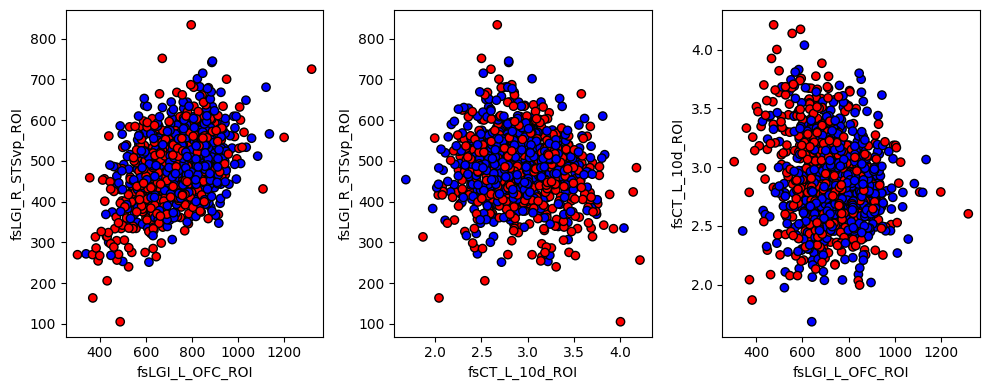

In [48]:
fs_vars = ['fsLGI_L_OFC_ROI', 'fsLGI_R_STSvp_ROI', 'fsCT_L_10d_ROI']
x, y, z = features[fs_vars].values.T

fig, ax = plt.subplots(1, 3)
ax[0].scatter(x, y, c=phenotypes['group'],edgecolors='k',cmap=cm_bright)
ax[0].set(xlabel=fs_vars[0], ylabel=fs_vars[1])
ax[1].scatter(z, y, c=phenotypes['group'],edgecolors='k',cmap=cm_bright)
ax[1].set(xlabel=fs_vars[2], ylabel=fs_vars[1])
ax[2].scatter(x, z, c=phenotypes['group'],edgecolors='k',cmap=cm_bright)
ax[2].set(xlabel=fs_vars[0], ylabel=fs_vars[2])
fig.set_tight_layout("tight")
fig.set_size_inches([10,4])

As can be seen, in real-world classification problems, classes are often very hard to separate cleanly, and distributions tend to overlap heavily in feature space? The red and blue  dots are the two groups of participants, and it's pretty clear at a glance that there isn't going to be any hyperplane we could plunk down through that plot that would perfectly separate the two groups. Again though, we're still using only 3 of our features here, and there are 1,337 others. So let's see how we do when we scale things up to higher dimensions.

### Applying classifiers

Okay, onto the actual classification. How do we apply classification estimators in Scikit-learn? It's a trick question! We've already covered it in the regression example. There's essentially no difference in the way we interact with regression and classification estimators; we just have to be careful not to pass discrete labels to regression estimators, or continuous labels to classification estimators. But mechanically, we construct and fit the models in the same way.

Let's try this out with a *gaussian Naive Bayes* (GNB) classifier. This is a simple classification approach based on a "naive" application of Bayes' Theorem.
The naivete stems from the classifier's assumption that all features are independent of one another once we condition on class assignment. This assumption greatly simplifies analysis, though it's nearly always false. GNB is a good classifier to use as a performance baseline, because it does surprisingly well in many situations and is extremely computationally efficient, so it should be quick. Naive Bayes classifiers have no trouble handling large sets of highly correlated features and are also relatively resilient to overfitting (Overfitting may happen when you have too many features. Then you can get results that are "too good" and do not generalise to new data). So we'll just throw everything we have at the classifier, and try to predict the diagnosis class from all 1,440 features.

In [49]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y = phenotypes['group']
gnb = gnb.fit(features, y)

That's all there is to it! See how similar the code is to the regression example we did before?

### Evaluating classification performance

We already know how to obtain a performance estimate from the built-in scorer, so let's do that:

In [50]:
print(gnb.score(features, y))

0.6254980079681275


In this case, the default scoring metric is just overall accuracy (i.e., the proportion of all samples that were assigned to the correct class). We see that the model classifies about 63% of samples correctly.

Is 63% good or bad? As always, it depends. It's nowhere near good enough to be
useful in practical applications; on the other hand, it's better than randomly
guessing. Or is it? That would only be the case if there is an equal number of
participants that were diagnosed with autism as there are healthy controls. In
some datasets, there might be a *class imbalance*, in which case, randomly
guessing might do better than 50% (for example, by guessing that everyone
belongs to the more prevalent class). This is something that needs to be taken
into account when evaluating classification results. Fortunately, we can compute
some more nuanced scores.

#### Classification reports

The raw accuracy score is a good place to start when evaluating performance, but it often masks important nuances. We can get some more information using the `classification_report` utility, which breaks down classification performance into separate `precision`, `recall`, and `f1-score`  metrics (we could also get each of these individually from the `sklearn.metrics` module). Precision is also known as positive predictive value; it tells us the proportion of cases labeled as positive that truly are positive (e.g., the proportion of cases the classifier labels autistic that really are autistic). Recall (or sensitivity) tells us the proportion of true positive cases that were labeled as such by the classifier. The F1 score is the harmonic mean of recall and sensitivity and thus tries to summarize both using a single quantity.

The `classification_report` function reports these quantities both for the dataset as a whole, and broken down separately for each class:

In [51]:
from sklearn.metrics import classification_report
y_pred = gnb.predict(features)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

         1.0       0.63      0.44      0.52       463
         2.0       0.62      0.78      0.69       541

    accuracy                           0.63      1004
   macro avg       0.63      0.61      0.61      1004
weighted avg       0.63      0.63      0.61      1004



Notice that while the precision, in this case, is almost identical for the two groups, the recall (or sensitivity) differs substantially: control subjects have a higher probability (78%) of being correctly labeled than subjects with an autism diagnosis (44%). This suggests a bias in the model—namely, that the model is more likely to assign cases to the control group than the autism group. We can verify this by looking at the overall proportion of cases our trained model labels as controls:

In [52]:
(y_pred == 2).mean()

0.6762948207171314

Sure enough, over two-thirds of cases are classified as controls, even though the ground truth is that only 54% of the sample is made up of controls.

Note that whether this bias in the trained model is a good or bad thing depends on one's context and goals. In the real world, there are often asymmetries in the costs associated with assigning different labels. For example, an HIV test should probably try very hard to minimize false negatives, because the cost of incorrectly telling someone they don't have HIV is likely to be higher than the cost of incorrectly telling them they *do* have HIV (seeing as follow-up tests will rapidly identify the latter error). On the other hand, if all we care about is maximizing overall classification accuracy for its own sake (e.g., as a learning exercise), then we might be perfectly happy to accept a model with these kinds of class-wise biases, providing their introduction helps us improve our overall performance.

## Non-parametric permutation methods for calculating corrected p-values

Permutation tests are a class of non-parametric methods. They were pioneered by Fisher (1935) and Pitman (1937). Fisher demonstrated that the null hypothesis could be tested simply by observing, after permuting observations, how often the difference between means would exceed the difference found without permutation, and that for such test, no normality would be required.

![permutation_stats.jpg](images/permutation_stats.jpg)

If we are comparing two samples (e.g. `treatment` and `control`), we can calculate the effect, we get when shuffling the category labels.

![Permutation_test_example_animation.gif](images/Permutation_test_example_animation.gif)
Source:[Wikipedia](https://en.wikipedia.org/wiki/Permutation_test)

The percentage of values we get that are bigger than our original value, represents the probability that our value comes from the null-distribution.

Permutation tests are built into `Scikit-learn`:

In [53]:
from sklearn.model_selection import StratifiedKFold, permutation_test_score
cv = StratifiedKFold(2, shuffle=True, random_state=0)

score_asd, perm_scores_asd, pvalue_asd = permutation_test_score(
    gnb, features, y, scoring="accuracy", cv=cv, n_permutations=1000
)

Below we plot a histogram of the permutation scores (the null distribution). The red line indicates the score obtained by the classifier on the original data. The score is much better than those obtained by using permuted data and the p-value is thus very low. This indicates that there is a low likelihood that this good score would be obtained by chance alone. It provides evidence that the dataset contains real dependency between features and labels and the classifier was able to utilize this to obtain good results.

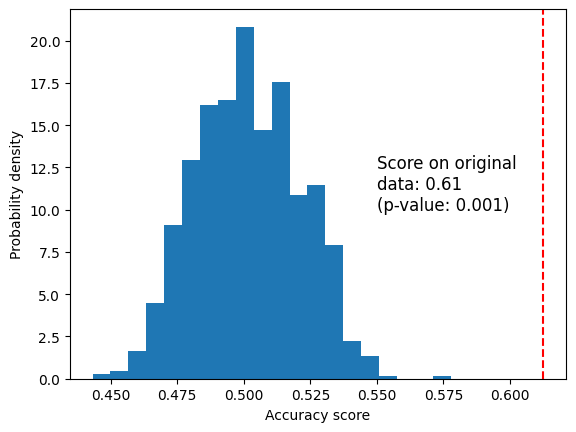

In [54]:
fig, ax = plt.subplots()

ax.hist(perm_scores_asd, bins=20, density=True)
ax.axvline(score_asd, ls="--", color="r")
score_label = f"Score on original\ndata: {score_asd:.2f}\n(p-value: {pvalue_asd:.3f})"
ax.text(0.55, 10, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability density")

Below we plot the null distribution for a completely randomized data. The permutation scores are similar to those obtained using the original dataset because the permutation always destroys any feature label dependency present. The score obtained on the original randomized data in this case though, is very poor. This results in a large p-value, confirming that there was no feature label dependency in the original data.

In [55]:
import numpy as np

rng = np.random.RandomState(seed=0)
# Use same number of samples and features as in autism dataset
X_rand = rng.normal(size=(features.shape[0], features.shape[1]))

score_rand, perm_scores_rand, pvalue_rand = permutation_test_score(
    gnb, X_rand, y, scoring="accuracy", cv=cv, n_permutations=1000
)

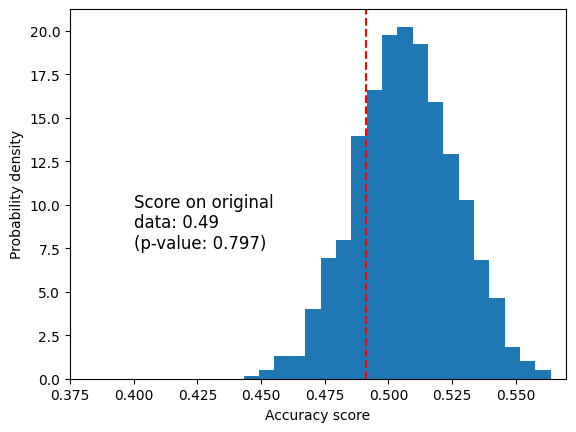

In [56]:
fig, ax = plt.subplots()

ax.hist(perm_scores_rand, bins=20, density=True)
ax.set_xlim(0.375)
ax.axvline(score_rand, ls="--", color="r")
score_label = f"Score on original\ndata: {score_rand:.2f}\n(p-value: {pvalue_rand:.3f})"
ax.text(0.4, 7.5, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
ax.set_ylabel("Probability density")
plt.show()

### Outro
Obviously, there is much more to say about classification analysis, but this will get us started.